Modifications to the simple Method


In [1]:
import phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from Python_Scripts.Data_Selection import *
from Python_Scripts.Data_Selection_for_BD import *
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

In [2]:
# Load CSV into a DataFrame
file = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
data = pd.read_csv(file)

# Display the first few rows of the data
print(data.head())

   Unnamed: 0  cellidx      TBX6       BRA      CDX2      SOX2      SOX1  \
0           0        0  0.541198  0.228724  1.136731  2.638387  0.676792   
1           1        1  0.562709  0.153176  1.251472  0.776583  0.694261   
2           2        2  0.637590  0.240679  1.486664  3.752942  0.682324   
3           3        3  0.640359  0.184531  1.614646  4.068103  0.828319   
4           4        4  0.639919  0.153728  1.823096  2.079683  0.990685   

                   filename  timepoint  sample  cluster_assignment_corrected  \
0  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
1  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
2  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
3  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   
4  D2.5_A2_A02_003.fcs .csv        2.5       0                             0   

   cluster_post_replacement  synthetic  
0                    

In [4]:
# Step 1: Drop irrelevant columns
genes = data.drop(data.columns[[0, 1, 7, 9, 10]], axis=1)

# Step 2: Filter for valid timepoints
valid_timepoints_for_1 = [2.0, 2.5, 3.0, 3.5]
filtered_df = genes[genes['timepoint'].isin(valid_timepoints_for_1)]

amount_desired = 6000

# Step 3: Select up to 2000 samples from each desired cluster
cell_types_0 = filtered_df[filtered_df['cluster_post_replacement'] == 0][:amount_desired]
cell_types_1 = filtered_df[filtered_df['cluster_post_replacement'] == 1][:amount_desired]
cell_types_2 = filtered_df[filtered_df['cluster_post_replacement'] == 2][:amount_desired]
cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'] == 3][:amount_desired]

# Step 4: Combine selected data
combination_of_data = pd.concat(
    [cell_types_0, cell_types_1, cell_types_2, cell_types_3],
    axis=0
).reset_index(drop=True)

# Step 5: Prepare PHATE input (drop timepoint and cluster labels)
phate_data = combination_of_data.drop(
    combination_of_data.columns[[5, 6, 7]], axis=1
)

print(len(phate_data))

22340


In [5]:
#I am doing an embedding on only the first decision but it may be more useful to consider the whole framework firstly and then color the binary decisions 
phate_op = phate.PHATE(
    random_state=42,
    knn=4,           # slightly larger neighborhood to stabilize the graph
    decay=200,         # good balance of locality
    t='auto',    # high diffusion time for smooth trajectories
)

# Slice the first 8000 rows
embedding_2D = phate_op.fit_transform(phate_data)




Calculating PHATE...
  Running PHATE on 22340 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 1.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.10 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.72 seconds.
  Calculated landmark operator in 5.28 seconds.
  Calculating optimal t...
    Automatically selected t = 38
  Calculated optimal t in 3.22 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.88 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.44 seconds.
Calculated PHATE in 12.90 seconds.


[[0.08705538 0.         0.         ... 0.         0.         0.        ]
 [0.         0.07801255 0.         ... 0.         0.         0.        ]
 [0.         0.         0.14146564 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.10545489 0.         0.        ]
 [0.         0.         0.         ... 0.         0.08426097 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15042868]]


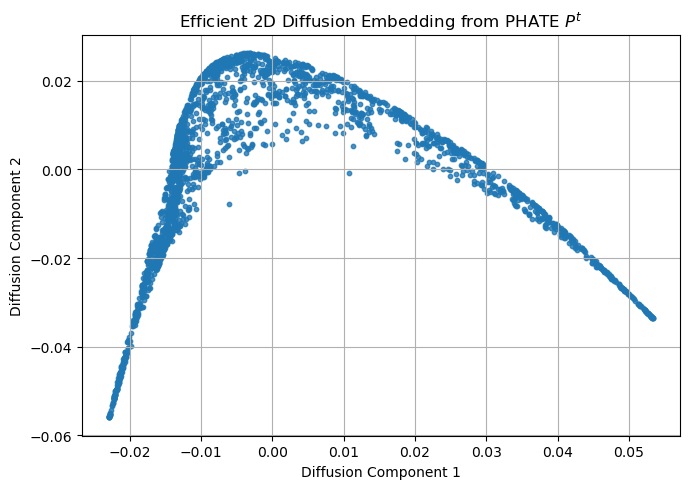

In [48]:
from scipy.sparse.linalg import eigs  # sparse and partial eigendecomposition

# Extract diffusion operator P
P = phate_op.diff_op

print(P)

# Efficient power operation through matrix-vector multiplication
def matvec_power(v):
    x = v
    for _ in range(phate_op.t):
        x = P @ x
    return x

# Wrap in a linear operator to avoid explicit P^t
from scipy.sparse.linalg import LinearOperator

n = P.shape[0]
P_t_linop = LinearOperator((n, n), matvec=matvec_power, dtype=np.float64)

# Get top 3 eigenpairs of P^t (skip the trivial 1st)
eigvals, eigvecs = eigs(P_t_linop, k=3, which='LR')  # 'LR' = largest real part

# Sort and take real part
idx = np.argsort(-np.abs(eigvals))
eigvals = eigvals[idx].real
eigvecs = eigvecs[:, idx].real

# Create 2D embedding
embedding_2D = eigvecs[:, 1:3] * eigvals[1:3]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(embedding_2D[:, 0], embedding_2D[:, 1], s=10, alpha=0.8)
plt.title("Efficient 2D Diffusion Embedding from PHATE $P^t$")
plt.xlabel("Diffusion Component 1")
plt.ylabel("Diffusion Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


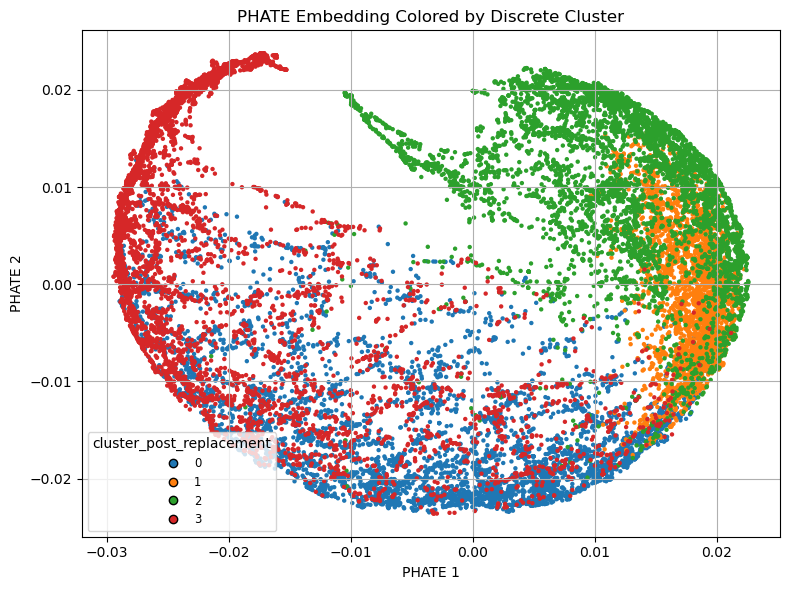

In [6]:
# 1. Extract cluster labels
clusters = combination_of_data['cluster_post_replacement'].values
unique_clusters = sorted(np.unique(clusters))  # Ensure consistent ordering

# 2. Map each cluster to an index
cluster_to_code = {cluster: i for i, cluster in enumerate(unique_clusters)}
color_codes = np.array([cluster_to_code[c] for c in clusters])

# 3. Define a custom color palette
custom_cmap = ListedColormap([
    "#1f77b4",  # dark blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf"   # cyan
][:len(unique_clusters)])  # truncate if fewer than 10 clusters

# 4. Plot PHATE embedding with discrete colors
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_2D[:, 0], embedding_2D[:, 1],
    c=color_codes,
    cmap=custom_cmap,
    s=10,
    alpha=1.0,
    edgecolors='none'
)

# 5. Custom legend (color matched to cluster label)
handles = [
    plt.Line2D([], [], marker='o', linestyle='',
               label=str(cluster),
               markerfacecolor=custom_cmap(code),
               markeredgecolor='k',
               markersize=6)
    for cluster, code in cluster_to_code.items()
]

plt.legend(handles=handles, title='cluster_post_replacement', loc='best', fontsize='small')
plt.title('PHATE Embedding Colored by Discrete Cluster')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# --- Step 0: Assume these are already defined ---
# embedding_2D: (n_samples, 2) - your intrinsic manifold coords (from PHATE eigendecomposition)
# X: (n_samples, 5) - your high-dimensional data

# Simulate them here for demo purposes — replace with real values

# --- Step 1: Define decoder model: R^2 → R^5 ---
latent_input = layers.Input(shape=(2,))
x = layers.Dense(64, activation='relu')(latent_input)
x = layers.Dense(128, activation='relu')(x)
x_output = layers.Dense(5)(x)

decoder = Model(inputs=latent_input, outputs=x_output)

# --- Step 2: Define custom loss with distance preservation ---
def distance_preserving_loss(x_true, x_pred, z_batch, lambda_dist=1.0):
    # Reconstruction loss
    recon_loss = tf.reduce_mean(tf.square(x_true - x_pred))

    # Pairwise distances in latent and decoded spaces
    z_dist = tf.norm(tf.expand_dims(z_batch, axis=1) - tf.expand_dims(z_batch, axis=0), axis=-1)
    x_dist = tf.norm(tf.expand_dims(x_pred, axis=1) - tf.expand_dims(x_pred, axis=0), axis=-1)

    # Distance preservation loss
    dist_loss = tf.reduce_mean(tf.square(x_dist - z_dist))

    return recon_loss + lambda_dist * dist_loss

# --- Step 3: Custom training loop ---
optimizer = tf.keras.optimizers.Adam()
loss_history = []

z_tensor = tf.convert_to_tensor(embedding_2D, dtype=tf.float32)
x_tensor = tf.convert_to_tensor(phate_data, dtype=tf.float32)

for epoch in range(50):
    with tf.GradientTape() as tape:
        x_pred = decoder(z_tensor)
        loss = distance_preserving_loss(x_tensor, x_pred, z_tensor, lambda_dist=1.0)
    grads = tape.gradient(loss, decoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, decoder.trainable_weights))
    loss_history.append(loss.numpy())




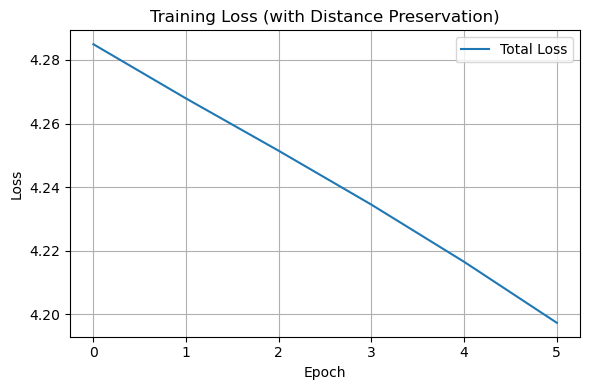

In [8]:

# --- Step 4: Plot training loss ---
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (with Distance Preservation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


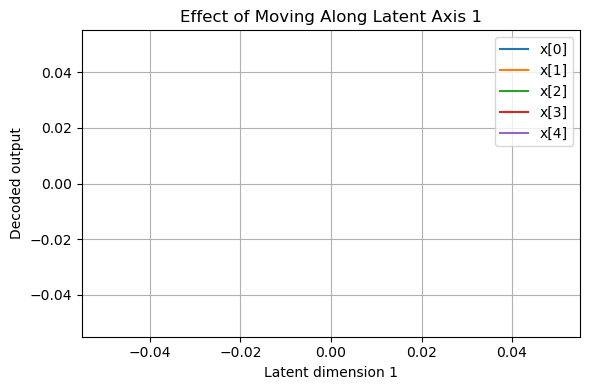

In [9]:
# --- Step 5: Plot decoded variation along latent axis 1 ---
z_grid = np.linspace(-3, 3, 100)
z_probe = np.stack([z_grid, np.zeros_like(z_grid)], axis=1)
decoded = decoder.predict(z_probe)

plt.figure(figsize=(6, 4))
for i in range(5):
    plt.plot(z_grid, decoded[:, i], label=f"x[{i}]")
plt.xlabel("Latent dimension 1")
plt.ylabel("Decoded output")
plt.title("Effect of Moving Along Latent Axis 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# --- Step 6: Jacobian at a single point ---
z_sample = tf.convert_to_tensor(embedding_2D[:1], dtype=tf.float32)  # first point
with tf.GradientTape() as tape:
    tape.watch(z_sample)
    x_decoded = decoder(z_sample)
jacobian = tape.batch_jacobian(x_decoded, z_sample)

print("Decoded 5D vector:", x_decoded.numpy())
print("Jacobian shape:", jacobian.shape)  # Should be (1, 5, 2)

Decoded 5D vector: [[nan nan nan nan nan]]
Jacobian shape: (1, 5, 2)


In [11]:
print(phate_data[:1])
print(embedding_2D[:1])

       TBX6       BRA      CDX2      SOX2      SOX1
0  0.541198  0.228724  1.136731  2.638387  0.676792
[[-0.01067035 -0.02044539]]


In [12]:
predicted_x = decoder.predict(embedding_2D[:1])
print(predicted_x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[nan nan nan nan nan]]
